In [1]:
import time
import os
import io

from random import seed
from random import randint

from argparse import ArgumentParser, Namespace
import yaml
from multiprocessing import cpu_count

import matplotlib.pyplot as plt

# default is to maximize the objectives
import time as time
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy.stats import norm

# example of a gaussian process surrogate function
from math import sin
from math import pi
import numpy as np
from numpy import arange
from numpy import asarray
from numpy.random import normal
from numpy.random import uniform
from numpy.random import random
from numpy import cov

from warnings import catch_warnings
from warnings import simplefilter


from autooed.utils.sampling import lhs
import random
#import xgboost as xgb
#from xgboost import XGBRegressor
#from xgboost import plot_tree
from sklearn import linear_model
from sklearn import ensemble
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from scipy.stats import pearsonr as pearsonr
from scipy import ndimage, misc
import pickle
import re
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from chainer_chemistry.datasets.molnet import get_molnet_dataset
# the package is in the same directory
# get Today's date from python!
from datetime import datetime
from autooed.utils.sampling import lhs
from autooed.problem import build_problem
from autooed.mobo import build_algorithm
from autooed.utils.seed import set_seed
from autooed.utils.initialization import generate_random_initial_samples, load_provided_initial_samples
from autooed.utils.plot import plot_performance_space, plot_performance_metric
from autooed.utils.plot import plot_performance_space_diffcolor
from argparse import ArgumentParser, Namespace
from arguments import get_args

/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kianoosh/github/MOBO_RFcons_LCD3D_6monomers/autooed/mobo/surrogate_problem.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, y_train)


1.0
0.875


In [2]:
# printability as Y
df = pd.read_csv('Yuchao_20220721.csv')
#df = pd.read_csv('Imaginery_initial_.csv')

Printability = np.asarray (df['Printability']).reshape(1,-1).T
Tg = np.asarray (df['Tg']).reshape(1,-1).T
Tg[np.isnan(Tg)] = 0
toughness = np.asarray (df['Toughness(MJ/m3)']).reshape(1,-1).T
toughness[np.isnan(toughness)] = 0
strength = np.asarray (df['Tensile_Strength(MPa)']).reshape(1,-1).T
strength[np.isnan(strength)] = 0
strain = np.asarray (df['Tensile_Strain_percentage']).reshape(1,-1).T
strain[np.isnan(strain)] = 0

Y0 = Printability
Y = np.where(Y0 == 'Y', 1, 0)

#X_ = df.to_numpy()
A_Ratio = np.asarray (df['R1(HA)']).reshape(1,-1)
B_Ratio = np.asarray (df['R2(IA)']).reshape(1,-1)
C_Ratio = np.asarray (df['R3(NVP)']).reshape(1,-1)
D_Ratio = np.asarray (df['R4(AA)']).reshape(1,-1)
E_Ratio = np.asarray (df['R5(HEAA)']).reshape(1,-1)
F_Ratio = np.asarray (df['R6(IBOA)']).reshape(1,-1)

# did not consider F_Ratio, since we do not have it in optimization
X_ = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T), axis=1)


# load monomers descriptors
df = pd.read_csv('monomers_info.csv')
energy = np.array (-df['dft_sp_E_RB3LYP'])
pol_area = np.array (df['polar_surface_area'])
complexity = np.array (df['complexity'])
HA = np.array (df['HA'])
solubility = np.array (df['solubility_sqrt_MJperm3'])
solubility_d = np.array (df['solubility_dipole'])
solubility_h = np.array (df['solubility_h'])
solubility_p = np.array (df['solubility_p'])

X0 = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T, F_Ratio.T), axis=1)
X_energy = np.multiply (X0, energy)
#X_pol_area = np.multiply (X0, pol_area)
X_complexity = np.multiply (X0, complexity)
X_HA = np.multiply (X0, HA)
X_solubility_d = np.multiply (X0, solubility_d)
X_solubility_h = np.multiply (X0, solubility_h)
X_solubility_p = np.multiply (X0, solubility_p)

X = np.concatenate ((X_energy, X_complexity, X_HA, 
                    X_solubility_d, X_solubility_h, X_solubility_p), axis=1)

accuracy_test = []
accuracy_train = []
# got more information about input varialbe may reduce the accuracy for 
# few samples, but it is informative for new samples.

# ratio accuracy for 1000 repeat: 0.915875
# energy  + complexity + HA + Solubility accuracy for 1000 repeat: 0.912875
# energy  + complexity + Solubility accuracy for 1000 repeat: 0.908625 ! HA is important
# energy  + HA + Solubility accuracy for 1000 repeat: 0.90925 ! complexity is important
# Complexity + HA + Solubility accuracy for 1000 repeat: 0.91175 ! energy term not that important
# energy  + complexity + HA : 0.91175 ! Solubility is not that important 
# complexity + HA : 0.915375 So close to only ratios. 
# complexity : 0.910875
# Solubility: 0.90675
# HA: 0.91075 
# Solubility_h : 0.911125
# HA + Solubility_h: 0.915875 !! same as only ratio
# HA + Complexity + Solubility_h: 0.913

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
y_train = y_train.ravel()

for i in range(0, 1):
    RF = RandomForestClassifier(max_depth=10, random_state=i, warm_start=True, n_estimators=50)
    RF.fit(X_train[5:,:], y_train[5:])
    pred = RF.predict_proba(X_train)
    #print (RF.score(X_train, y_train))
    #print (RF.score(X_test, y_test))
    accuracy_test.append(RF.score(X_test, y_test))
    accuracy_train.append(RF.score(X_train, y_train))
print (np.mean (np.array (accuracy_train)))
print (np.mean (np.array (accuracy_test)))

0.96875
0.75


In [3]:
# retrain the model with new data
RF.n_estimators = int (5 * RF.n_estimators)
RF2 = RF.fit(X_train[0:5,:], y_train[0:5])
pred = RF2.predict_proba(X_train)
print (RF2.score(X_train, y_train))
print (RF2.score(X_test, y_test))


0.9375
0.75


In [4]:
# consider 0 < Tg < 50 as group 1 and others 0
Tg_group = [1 if 10<i<60 else 0 for i in Tg]
accuracy_test = []
accuracy_train = []
for i in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(X, Tg_group, test_size=0.2, random_state=i)
    #y_train = y_train.ravel()
    RF_tg = RandomForestClassifier(max_depth=40, random_state=i)
    RF_tg.fit(X_train, y_train)
    pred = RF_tg.predict_proba(X_train)
    accuracy_test.append(RF_tg.score(X_test, y_test))
    accuracy_train.append(RF_tg.score(X_train, y_train))

print (np.mean (np.array (accuracy_train)))
print (np.mean (np.array (accuracy_test)))

1.0
0.84125


In [5]:
df0 = pd.read_csv('Yuchao_20220721.csv').fillna(0)
df_mechprop = df0[['Tensile_Strength(MPa)', 'Tensile_Strain_percentage', 
                   'Toughness(MJ/m3)', 'Tg']]
df_mechprop = df_mechprop.rename(columns={
              "Tensile_Strength(MPa)": "Strength", 
              "Tensile_Strain_percentage": "Strain",
              "Toughness(MJ/m3)": "Toughness"})

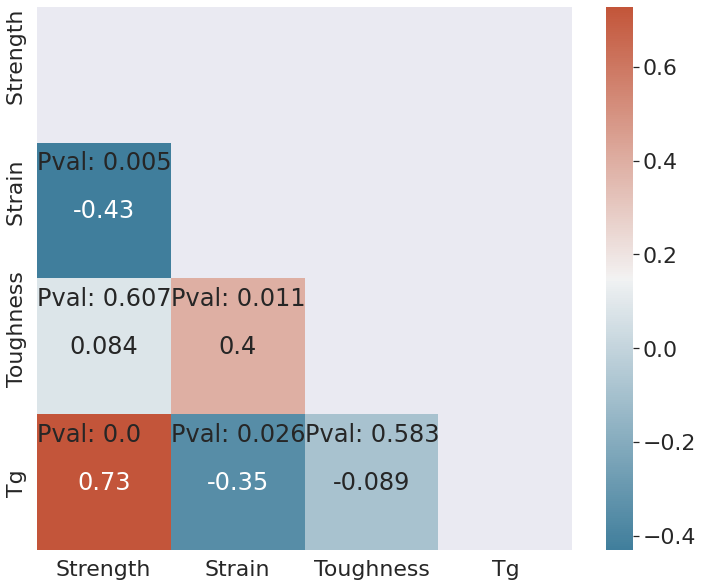

In [6]:
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
pvalue_pearson = df_mechprop.corr(method=pearsonr_pval)

corr = df_mechprop.corr(method='pearson')
sns.set(font_scale = 2)
f, ax = plt.subplots(figsize=(12, 10))
for i in range (0, 3):
    plt.text (i, i+1.2, 'Pval: {}'.format(np.round(pvalue_pearson.iloc[i, i+1], 3)))
for i in range (0, 2):
    plt.text (i, i+2.2, 'Pval: {}'.format(np.round(pvalue_pearson.iloc[i+2, i], 3)))
for i in range (0, 1):
    plt.text (i, i+3.2, 'Pval: {}'.format(np.round(pvalue_pearson.iloc[i+3, i], 3)))

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, yticklabels=['   Tg', 'T', 'Strain', 'Strength'])
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, 
            yticklabels=['     Strength', '     Strain', '     Toughness', 'Tg'])
plt.savefig('heatmap_allmechprop.png', dpi=200)

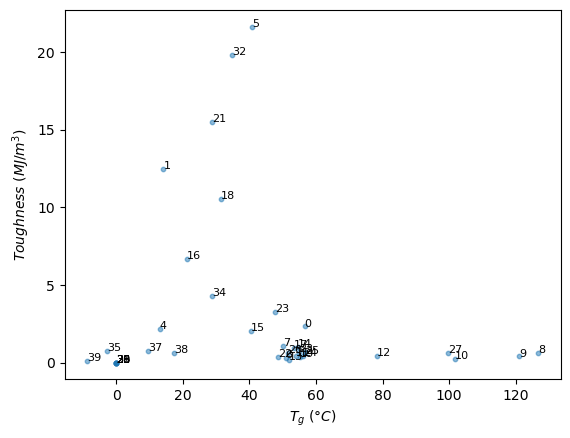

In [7]:
plt.style.use('default')
plt.scatter(Tg, toughness, alpha=0.5, s=10)

plt.xlabel(r'$T_g$ ($\degree C$)')
#plt.ylabel(r'$U_T$ $(MJ/m^3)$')
plt.ylabel(r'$Toughness$ $(MJ/m^3)$')

for i in range(toughness.shape[0]):
    #if toughness[i]>2:
        plt.text(Tg[i], toughness[i], str(i), fontsize=8)
plt.savefig('tough_Tg.png', dpi=500)

(0.7285804467055899, 9.836894364295938e-08)

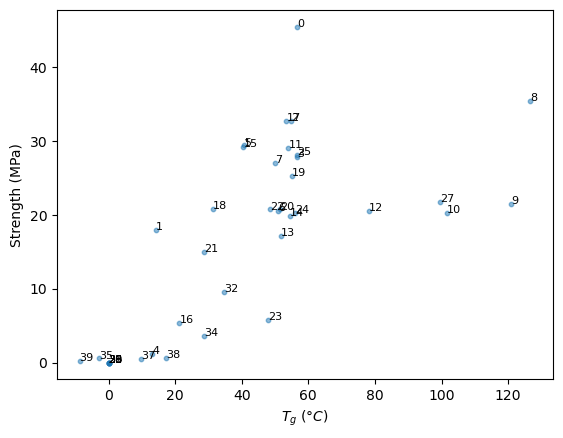

In [8]:
plt.scatter(Tg, strength, alpha=0.5, s=10)

plt.xlabel(r'$T_g$ ($\degree C$)')
#plt.ylabel(r'$U_T$ $(MJ/m^3)$')
plt.ylabel('Strength (MPa)')
 

for i in range(toughness.shape[0]):
    #if toughness[i]>2:
        plt.text(Tg[i], strength[i], str(i), fontsize=8)
plt.savefig('strength_Tg.png', dpi=200)

tg = Tg.reshape((-1, ))
s = strength.reshape((-1, ))

pearsonr(x=tg, y=s)

(0.08395218481757308, 0.606529082035115)

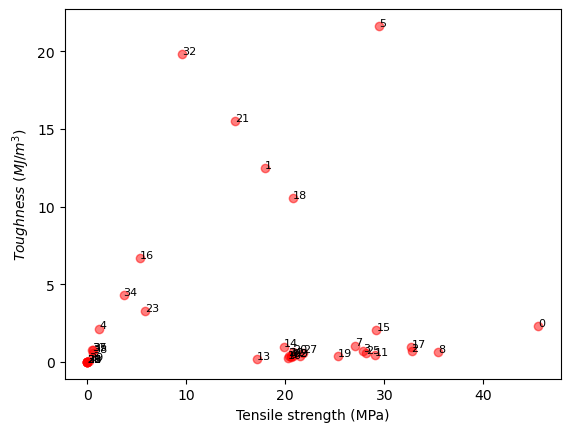

In [9]:
plt.scatter(strength, toughness, color='red', alpha=0.5)

plt.xlabel('Tensile strength (MPa)')
plt.ylabel(r'$Toughness$ $(MJ/m^3)$')

for i in range(toughness.shape[0]):
    #if toughness[i]>2:
        plt.text(strength[i], toughness[i], str(i), fontsize=8)
plt.savefig('tough_strength.png', dpi=200)

s = strength.reshape((-1, ))
t = toughness.reshape((-1, ))
pearsonr(x=s, y=t)

(-0.43132927036616237, 0.005455708698303401)

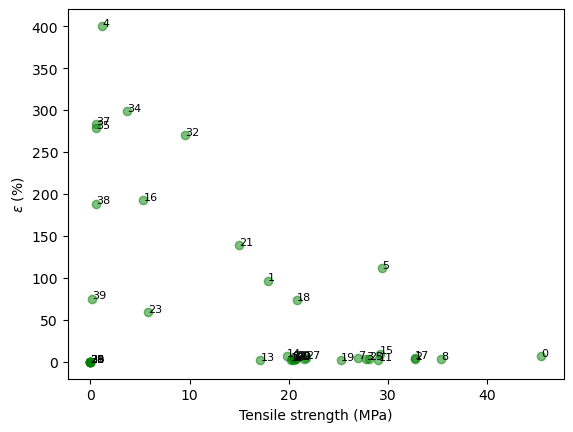

In [10]:
plt.scatter(strength, strain, color='green', alpha=0.5)

plt.xlabel('Tensile strength (MPa)')
plt.ylabel(r'$\epsilon$ $(\%)$')

for i in range(toughness.shape[0]):
    #if toughness[i]>2:
        plt.text(strength[i], strain[i], str(i), fontsize=8)
plt.savefig('strain_strength.png', dpi=200)

s = strength.reshape((-1, ))
e = strain.reshape((-1, ))
pearsonr(x=s, y=e)